## Challenge Overview
Optimize the resource plan using the provided incident dataset and station locations. 

### Objectives
- **Maximize incident response**: Determine the optimal number of officers at each station for every day.
- **Balance resources**: Avoid overstaffing to minimize officer downtime.

### Expectations
- It's acceptable to occasionally not meet response times; however, these instances must be justified.
- Consider tracking average response times and travel distances for various incident types.

Remember, the focus is on justifying your optimization strategy.




In [61]:
# Initial libraries 

import heapq
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
import random
import matplotlib.pyplot as plt
import requests
import json

In [62]:
# Constants 

# The radius of the Earth in miles
EARTH_RADIUS = 3958.8 # miles

# Average speed of a police officer traveling to an incident in miles per hour
AVERAGE_SPEED_MPH = 30 # MPH

# List of Priority from Standard - Immediate  
priority = [ 'Standard','Prompt','Immediate'] 


In [63]:
# functions
def meters_to_miles(meters):
    miles = meters / 1609.344
    return miles

def get_station_id_by_coords(lat, lon, station_locations, threshold=0.0001):
    # Iterate over the station_locations dictionary
    for station_id, coords in station_locations.items():
        # Check if the latitude and longitude are approximately equal
        if (abs(coords['Latitude'] - lat) < threshold and 
            abs(coords['Longitude'] - lon) < threshold):
            return station_id
    # Return None if no match found
    return None

In [64]:
#Loading the data

# Load the stations data from an Excel file
incident_data = pd.read_excel('../Data/data_Modifyed1.xlsx', sheet_name='Incident data week 1')
stations_df = pd.read_excel('../Data/data.xlsx', sheet_name='Stations')

incident_data['Latitude'] = incident_data['Latitude'].astype(float)
incident_data['Longitude'] = incident_data['Longitude'].astype(float)

# Extract station identifiers - 3 of the stations locations (lat1, lon1)
station_identifiers = stations_df['Station No.'].tolist() 

# Convert the stations DataFrame into a dictionary
station_locations = {row['Station No.']: {'Latitude': row['Latitude'], 'Longitude': row['Longitude']} 
                     for index, row in stations_df.iterrows()}


In [65]:
""" ------------------------- Priority Deadlines ------------------------- """
def calculate_response_deadline(hour, priority):
    """ Calculate the response deadline for an incident based on its priority. """
    if priority == 'Immediate':
        return hour + 1  # 1 hour deadline
    elif priority == 'Prompt':
        return hour + 3  # 3 hours deadline
    else:
        return hour + 6  # 6 hours deadline

def Get_response_deadline(priority):
    if priority == 'Immediate':
        return 1  # 1 hour deadline
    elif priority == 'Prompt':
        return 3  # 3 hours deadline
    else:
        return 6  # 6 hours deadline
    
def calculate_time_until_deadline(row, current_time):
    incident_time_elapsed = ((current_time + ((row['Day'] - 1) * 24 * 60)) - (row['Hour'] * 60 + ((row['Day'] - 1) * 24 * 60)))
    return -(calculate_response_deadline(row['Hour'], row['Priority'])*60 - incident_time_elapsed)



In [66]:
""" ------------------------- Calculate the Distance between crimes ------------------------- """
# haversine_distance used for obtaining the closest station 

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    rlat1, rlon1, rlat2, rlon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Compute differences in coordinates
    dlat = rlat2 - rlat1
    dlon = rlon2 - rlon1

    # Haversine formula to calculate the distance
    a = sin(dlat/2)**2 + cos(rlat1) * cos(rlat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = EARTH_RADIUS * c
    return distance

# Define a function to calculate travel time 
# calculate time given a distance with actual map data

def calculate_travel_time(station_location, incident_location):
    # Extract latitude and longitude directly from the station_location dictionary
    start_coord = (station_location['Latitude'], station_location['Longitude'])
    end_coord = incident_location  # Assuming incident_location is already a tuple of (lat, lon)

    # Calculate the Duration using the OSRM
    
    def get_osrm_distance_duration(start, end):
        url = f"http://router.project-osrm.org/route/v1/car/{start[1]},{start[0]};{end[1]},{end[0]}"
        response = requests.get(url)
        data = json.loads(response.text)
        distance = data['routes'][0]['distance']  # In meters
        duration = data['routes'][0]['duration']  # In seconds
        return distance, duration

    distance, duration = get_osrm_distance_duration(start_coord, end_coord)
    
    # Convert travel time to minutes for more granularity
    travel_time_minutes = duration/60
    
    return travel_time_minutes


In [67]:
SHIFT_PARAMS = {
    'Early': {'start_hour': 0, 'end_hour': 7, 'total_officers': 15, 'shift_name': 'Early'},
    'Day': {'start_hour': 8, 'end_hour': 15, 'total_officers': 25, 'shift_name': 'Day'},
    'Night': {'start_hour': 16, 'end_hour': 23, 'total_officers': 40, 'shift_name': 'Night'}
}

In [68]:
class Time:
    def __init__(self, shift_name):
        self.Time = shift_params = SHIFT_PARAMS[shift_name]['start_hour'] * 60 # Convert start hour to minutes

    def UpdateTime(self, addedTime_In_Minutes):
        self.Time += addedTime_In_Minutes
    
    def GetTime(self):
        return self.Time
    
def decimal_to_24h_time(decimal_hour):
    """
    Converts a decimal hour into 24-hour time format.

    Args:
    decimal_hour (float): The hour in decimal format.

    Returns:
    str: The time in 24-hour format.
    """

    # Extracting hours and minutes, ensuring hours stay within 0-23 range
    hours = int(decimal_hour) % 24
    minutes = int((decimal_hour - int(decimal_hour)) * 60)

    # Formatting the time in 24-hour format
    return f"{hours:02d}:{minutes:02d}"

def decimal_to_time(decimal_hour):
    """
    Converts a decimal hour into 24-hour time format.

    Args:
    decimal_hour (float): The hour in decimal format.

    Returns:
    str: The time in 24-hour format.
    """

    # Extracting hours and minutes
    hours = int(decimal_hour)
    minutes = int((decimal_hour - hours) * 60)

    # Formatting the time in 24-hour format
    return hours, minutes


In [69]:
class Officer:
        def __init__(self, station_id, shift_type):
            self.station_id = station_id
            self.shift_type = shift_type
            self.available = True
            self.current_incident = None
            self.available_at = SHIFT_PARAMS[shift_type]['start_hour']*60              
            self.incidents_handled = 0  # Track number of incidents handled
            self.active_time = 0  # Track total active time 
            self.Idle_Time = 0 # Track total Idle time

        def assign_incident(self, incident):
            """ Assign an incident to the officer and update availability. """
            self.incidents_handled += 1
            self.current_incident = incident
            self.available = False
            self.priority = incident['Priority']  # Adding priority attribute from the incident

        def complete_incident(self, handling_time):
            """ Mark the current incident as complete, update availability, and add handling time. """
            self.current_incident = None
            self.available = True
            self.active_time += handling_time  # Add the handling time to the officer's active time

        def GetIdleTime(self):
            return (SHIFT_PARAMS[self.shift_type]['end_hour'] - SHIFT_PARAMS[self.shift_type]['start_hour'])*60 - self.active_time

        def is_available(self):
            """ Check if the officer is available for assignment. """
            return self.available
        
        def update_location_and_availability(self, new_location, availability_time):
            """ Update the officer's location and the time they will become available. """
            self.location = new_location
            self.available_at = availability_time  # Time when the officer will be available again


In [70]:
def find_closest_stations_for_incidents(incidents, station_locations):
    closest_stations = {}

    for index, incident in incidents.iterrows():
        closest_station_id = None
        shortest_distance = float('inf')
        incident_location = (incident['Latitude'], incident['Longitude'])

        for station_id, location in station_locations.items():
            station_location = (location['Latitude'], location['Longitude'])
            distance = haversine_distance(station_location[0], station_location[1], incident_location[0], incident_location[1])

            if distance < shortest_distance:
                shortest_distance = distance
                closest_station_id = station_id

        closest_stations[index] = closest_station_id

    return closest_stations

def remove_stations(station_ids, station_locations):
    for station_id in station_ids:
        if station_id in station_locations:
            del station_locations[station_id]
            print(f"Station {station_id} has been removed.")
        else:
            print(f"Station {station_id} not found.")



In [71]:
def allocate_officers_to_stations(shift_name, officers_distribution):
    officers = []

    # Ensure the distribution list length matches the number of stations
    if len(officers_distribution) != len(station_identifiers):
        raise ValueError("Officers distribution does not match the number of stations.")

    # Initialize officers for each station based on the distribution
    for station_index, num_officers in enumerate(officers_distribution):
        for _ in range(num_officers):
            officers.append(Officer(station_identifiers[station_index], shift_name))

    return officers

def allocate_officers_to_stations_Evenly(shift_name): 
    officers = []

    # Get the total officers for this shift
    total_officers_per_shift = SHIFT_PARAMS[shift_name]['total_officers']
    total_stations = len(station_identifiers)
    officers_per_station = total_officers_per_shift // total_stations

    # Initialize officers for each station
    for station_id in station_identifiers:
        for _ in range(officers_per_station):
            officers.append(Officer(station_id, shift_name))

    # Handle any remainder officers if total officers are not evenly divisible by number of stations
    remainder_officers = total_officers_per_shift % total_stations
    for i in range(remainder_officers):
        officers.append(Officer(station_identifiers[i], shift_name))

    return officers

def amount_of_Officers_in_station(station_id, officers_list):
    """
    Returns the amount of officers in a given station.

    Args:
    station_id (int): The identifier for the station.
    officers_list (list): The list of Officer objects.

    Returns:
    int: The number of officers in the specified station.
    """
    # Count the officers in the given station
    count = sum(1 for officer in officers_list if officer.station_id == station_id)
    return count

def split_solution_by_shifts(solution, shift_lengths):
    """
    Splits the solution into allocations for different shifts.

    Args:
        solution (list): The entire solution array representing officer allocations for all shifts.
        shift_lengths (dict): A dictionary with shift names as keys and the number of officers per shift as values.

    Returns:
        dict: A dictionary with shift names as keys and lists of officer allocations as values.
    """

    split_solutions = {}
    start_index = 0

    for shift, length in shift_lengths.items():
        # Extract the segment of the solution corresponding to this shift
        end_index = start_index + length
        split_solutions[shift] = solution[start_index:end_index]

        # Update the start index for the next shift
        start_index = end_index

    return split_solutions

def calculate_officers_idle_times(officers):

    """
    Calculates the idle times of all officers.

    Args:
        officers (list): A list of Officer objects.

    Returns:
        list: A list of idle times for each officer.
    """

    Officer_Idle_Time = []

    for officer in officers:
        idle_time = officer.GetIdleTime()
        Officer_Idle_Time.append(idle_time)

    return Officer_Idle_Time

def calculate_average(numbers):
    if not numbers:  # Check if the list is empty
        return 0

    total_sum = sum(numbers)
    count = len(numbers)
    average = total_sum / count

    return average


In [72]:
# Priority Logic 

def PriorityLogicHourly(incidents_in_hour, current_time): 
        # sorting by Deployment Time
        priority_mapping = {'Immediate': 1, 'Prompt': 2, 'Standard': 3}
        incidents_in_hour['Priority_Num'] = incidents_in_hour['Priority'].map(priority_mapping)
        incidents_in_hour['Deployment_Score'] = 1 / incidents_in_hour['Deployment Time (hrs)']
        incidents_in_hour['Combined_Score'] = incidents_in_hour['Priority_Num'] * incidents_in_hour['Deployment_Score']

        # Now sort by 'Day', then 'Hour', then 'Combined_Score' to get the optimal order for response
        incidents_in_hour = incidents_in_hour.sort_values(by=['Day', 'Hour', 'Combined_Score'], ascending=[True, True, False])

        # if deadline has one hour left then push it on top of the list

        incidents_in_hour['Time_Until_Deadline'] = incidents_in_hour.apply(
            lambda row: calculate_time_until_deadline(row, current_time), 
            axis=1
        )

        incidents_in_hour = incidents_in_hour.sort_values(
            by=['Priority_Num', 'Time_Until_Deadline', 'Combined_Score'],
            ascending=[True, True, False]
        )

        # After sorting, you can remove the auxiliary columns if they are no longer needed
        incidents_in_hour = incidents_in_hour.drop(['Time_Until_Deadline', 'Priority_Num', 'Deployment_Score', 'Combined_Score'], axis=1)

        # 'Immediate' priority incidents are allocated at the top 
        immediate_incidents = incidents_in_hour[incidents_in_hour['Priority'] == 'Immediate']
        non_immediate_incidents = incidents_in_hour[incidents_in_hour['Priority'] != 'Immediate']
        sorted_incidents = pd.concat([immediate_incidents, non_immediate_incidents])
        incidents_in_hour = sorted_incidents

        return incidents_in_hour

def priorityLogicMinute(incidents):
        pass

In [73]:
# Shift Simulation

def allocate_officers(incident, officers, current_time):
    best_officer = None
    min_travel_time = float('inf')
    OfficerList = []

    # determine best station. 

    best_station = incident['closest_station']

    # loop through officers and check if any of them are avaiable in the station

    for officer in officers:
        if officer.is_available() and current_time >= officer.available_at:
            if officer.station_id == best_station:
                min_travel_time = incident['travel_time']
                print(f"\nAllocating Officer from Station {officer.station_id} to Incident at ({incident['Latitude']}, {incident['Longitude']}) at Time: {decimal_to_24h_time(current_time/60)}")
                return officer, min_travel_time
        OfficerList.append(officer)
        

    # if none are avaiable determine next best station

    officers = OfficerList

    for officer in officers: # gets best avaiable officer for the incident
            
        if officer.is_available() and current_time >= officer.available_at: 
            travel_time = (incident[f'distance_from_station_{officer.station_id}.0']) # its actually the time mistake on the database

            if travel_time < min_travel_time:
                min_travel_time = travel_time
                best_officer = officer

    if best_officer:
        print(f"\nAllocating Officer from Station {best_officer.station_id} to Incident at ({incident['Latitude']}, {incident['Longitude']}) at Time: {decimal_to_24h_time(current_time/60)}")

    return best_officer, (min_travel_time)

def handle_incident(officer, incident, current_time, shift_params, day, travel_time):

    # Calculate travel time to the incident
    officer_location = station_locations[officer.station_id]
    incident_location = (incident['Latitude'], incident['Longitude'])

    # time for handling the incident
    handling_time = incident['Deployment Time (hrs)']*60 # in minutes

    # Update officer's location and availability
    finish_time = (current_time + travel_time + handling_time)
    officer.update_location_and_availability(incident_location, finish_time)

    # Call complete_incident to update active time
    officer.complete_incident(travel_time + handling_time)
    print(f"Officer from Station {officer.station_id} handled an incident. finshed at Day: {day} time: {decimal_to_24h_time(finish_time/60)} Hrs.\n")

    # incident time elapsed + travel time
    incident_time_elapsed = ((current_time+((day-1)*24*60)) - (incident['Hour']*60+((incident['Day']-1)*24*60)))

    if ((travel_time + incident_time_elapsed)/60) >= Get_response_deadline(incident['Priority']):
        Hours, Minutes = decimal_to_time((incident_time_elapsed + travel_time)/60)
        print(f"Officer Has not completed Incident within deadline: {(incident['Priority'])} : {Get_response_deadline(incident['Priority'])} Hours, Time taken to Respond: {Hours} Hours {Minutes} Minutes\n")
        return {'Deadline_met': 0, 'Responce_time': (travel_time+handling_time)}
    return {'Deadline_met': 1, 'Responce_time': (travel_time+handling_time)} 

def simulate_shift(day, shift_name, incident_data, station_locations, leftover_incidents, Deadline_Met, total_incidents, Officers):
    shift_params = SHIFT_PARAMS[shift_name]

    if Officers:
        officers = allocate_officers_to_stations(shift_name, Officers)
    else:
        print(f"no officers arrangement was given, choosing even arrangement instead")
        officers = allocate_officers_to_stations_Evenly(shift_name) # make sure that allocation of officers to stations is optimised.

    print(f"Officers in Station 1: {amount_of_Officers_in_station(1, officers)}")
    print(f"Officers in Station 2: {amount_of_Officers_in_station(2, officers)}")
    print(f"Officers in Station 3: {amount_of_Officers_in_station(3, officers)}")

    # Filter and sort incidents by priority and time
    incidents_in_shift = incident_data[
        (incident_data['Day'] == day) &
        (incident_data['Hour'] >= shift_params['start_hour']) & 
        (incident_data['Hour'] <= shift_params['end_hour'])
    ].sort_values(by=['Hour', 'Priority'], ascending=[True, True])

    incidents_responded = 0
    incidents_missed = 0
    current_time = Time(shift_name).GetTime() # current time is in minutes
    incidents_in_shift = incidents_in_shift.copy()
    Responce_time = []

    # complete incidents for every hour in the shift
    for i in range(shift_params['end_hour'] - shift_params['start_hour']): # should always equal 7
        current_times_hour, current_times_Minute = decimal_to_time(current_time/60)
        incidents_in_hour = incidents_in_shift[incidents_in_shift['Hour'].eq(int(current_times_hour))] # gets all incidents in the hour
        incidents_in_hour = pd.concat([incidents_in_hour, leftover_incidents]).drop_duplicates().reset_index(drop=True)
        leftover_incidents = pd.DataFrame()  # Reset the leftover incidents

        # Priority Logic Hourly - (Optmisation Part)

        # incidents_in_hour = PriorityLogicHourly(incidents_in_hour, current_time)
        
        for j in range(1, 61): # iterate every minute of the hour

            # Priority Logic Per Minute
            # priorityLogicMinute(incidents_in_hour) # does nothing for now
             
            for index, incident in incidents_in_hour.iterrows():
                best_officer, travel_time = allocate_officers(incident, officers, current_time)

                if best_officer:
                    CompletedIncident = handle_incident(best_officer, incident, current_time, shift_params, day, travel_time)
                    Deadline_Met[incident['Priority']] += CompletedIncident['Deadline_met']
                    Responce_time.append(CompletedIncident['Responce_time']) 
                    total_incidents[incident['Priority']] += 1
                    incidents_in_hour.drop(index, inplace=True)

            if j == 60: 
                        leftover_incidents = pd.concat([leftover_incidents, incidents_in_hour])
            
            current_time += 1 # adds a minute to the time,

    Officer_Idle_Time = calculate_officers_idle_times(officers)
    Avg_Responce_times = calculate_average(Responce_time)

    return {
        'total_incidents': total_incidents, 
        'Priority Deadline Met': Deadline_Met,
        'leftover_incidents': leftover_incidents,  
        'Officer_Idle_Time': Officer_Idle_Time,
        'Avg_Responce_times': Avg_Responce_times
    }


In [74]:
# Day Simulation
def SimulateDay(day, solution):
        shifts = ['Early', 'Day', 'Night']
        leftover_incidents = pd.DataFrame()
        shift_lengths = {'Early': 3, 'Day': 3, 'Night': 3}
        shift_solutions = split_solution_by_shifts(solution, shift_lengths)
        Officer_Idle_Time = []
        
        Deadline_Met = {
                'Immediate':0,
                'Prompt':0,
                'Standard':0
        }

        total_incidents = { # total incidents the officers were able to respond to
                'Immediate':0,
                'Prompt':0,
                'Standard':0
        }

        for shift in shifts:
                print(f'Day: \'{day}\' shift: \'{shift}\'')
                data = simulate_shift(day, shift, incident_data, station_locations, leftover_incidents, Deadline_Met, total_incidents, shift_solutions[shift]) 
                leftover_incidents = data['leftover_incidents'] 
                Deadline_Met = data['Priority Deadline Met']
                total_incidents = data['total_incidents']
                Officer_Idle_Time = Officer_Idle_Time + data['Officer_Idle_Time'] 
                Avg_Responce_times = data['Avg_Responce_times']


        Percentageincidents = {  # total incidents the officers were able to respond to
        'Immediate': (Deadline_Met['Immediate'] / total_incidents['Immediate'] * 100) if total_incidents['Immediate'] > 0 else 0,
        'Prompt': (Deadline_Met['Prompt'] / total_incidents['Prompt'] * 100) if total_incidents['Prompt'] > 0 else 0,
        'Standard': (Deadline_Met['Standard'] / total_incidents['Standard'] * 100) if total_incidents['Standard'] > 0 else 0
        }

        NormalPercentageincidents = {  # Normalized total incidents the officers were able to respond to
        'Immediate': (Deadline_Met['Immediate'] / total_incidents['Immediate']) if total_incidents['Immediate'] > 0 else 0,
        'Prompt': (Deadline_Met['Prompt'] / total_incidents['Prompt']) if total_incidents['Prompt'] > 0 else 0,
        'Standard': (Deadline_Met['Standard'] / total_incidents['Standard']) if total_incidents['Standard'] > 0 else 0
        }



        return {'percentage_incidents_responded':Percentageincidents,
                'Normal_percentage_incidents_responded':NormalPercentageincidents,
                'leftover_incidents':leftover_incidents,
                'total_incidents':total_incidents,
                'Deadline_Met':Deadline_Met,
                'officers_idle_time': Officer_Idle_Time,
                'Avg_Responce_times': Avg_Responce_times}

def DisplaySimResults(SimulationResults):
        print(f"Deadline_met: {SimulationResults['Deadline_Met']}")
        print(f"total incidents solved: {SimulationResults['total_incidents']}")
        print(f"Idle_time: {calculate_average(SimulationResults['officers_idle_time'])}")
        print(f"Avg_Responce_time: {SimulationResults['Avg_Responce_times']}")

        for i in priority:
                print(f"Percentage of Incidents: {i} - {round(SimulationResults['percentage_incidents_responded'][i], 2)}%") 

##### Optmisation

In [75]:
# brute force calculation time

combinations = 5**9
computation_time_per_combination = 2.3  # in seconds

# Calculate total computation time in seconds
total_computation_time_seconds = combinations * computation_time_per_combination

# Convert seconds to hours
total_computation_time_days = (total_computation_time_seconds / 3600)/24

print(f"total days it will take: {round(total_computation_time_days, 2)} days")


total days it will take: 51.99 days


In [76]:
# redistribute officers logic

def redistribute_officers(allocation, max_officers):
    """
    Ensures that the total number of officers for each shift across all stations
    does not exceed the maximum limit.

    Args:
    allocation (list): The current allocation of officers.
    max_officers (list): Maximum officers allowed for each shift.

    Returns:
    list: Adjusted allocation that respects the maximum limits.
    """
    # Split allocation into shifts
    early_shift = allocation[:3]
    day_shift = allocation[3:6]
    night_shift = allocation[6:]

    # Adjust each shift's allocation
    early_shift = adjust_shift_allocation(early_shift, max_officers[0])
    day_shift = adjust_shift_allocation(day_shift, max_officers[1])
    night_shift = adjust_shift_allocation(night_shift, max_officers[2])

    # Combine the shifts back into a single allocation
    return early_shift + day_shift + night_shift

def adjust_shift_allocation(shift_allocation, max_officers):
    """
    Adjusts the allocation for a single shift.

    Args:
    shift_allocation (list): Allocation for a shift.
    max_officers (int): Maximum officers allowed for this shift.

    Returns:
    list: Adjusted allocation for the shift.
    """
    total_officers = sum(shift_allocation)

    # Reduce officers if over the limit
    while total_officers > max_officers:
        max_index = shift_allocation.index(max(shift_allocation))
        shift_allocation[max_index] -= 1
        total_officers -= 1

    # Add officers if under the limit
    while total_officers < max_officers:
        min_index = shift_allocation.index(min(shift_allocation))
        shift_allocation[min_index] += 1
        total_officers += 1

    return shift_allocation



In [77]:
# Randomly Generate Intial Solutions for GA

max_officers_early = SHIFT_PARAMS['Early']['total_officers']
max_officers_day = SHIFT_PARAMS['Day']['total_officers']
max_officers_night = SHIFT_PARAMS['Night']['total_officers']

def generate_random_allocation():
    # Function to generate random allocations for a shift across stations
    def allocate_for_shift(max_officers):
        remaining_officers = max_officers
        shift_allocation = []
        for _ in range(2):
            allocated = random.randint(0, remaining_officers)
            shift_allocation.append(allocated)
            remaining_officers -= allocated
        shift_allocation.append(remaining_officers)
        return shift_allocation

    allocation = []
    allocation.extend(allocate_for_shift(max_officers_early))
    allocation.extend(allocate_for_shift(max_officers_day))
    allocation.extend(allocate_for_shift(max_officers_night))

    # Apply redistribution
    return redistribute_officers(allocation, [max_officers_early, max_officers_day, max_officers_night])


In [78]:
def evaluate_fitness(day, solution):
    # Simulate the shift with the given solution
    simulation_result = SimulateDay(day, solution) 

    # Extract necessary metrics
    normalized_incidents_responded = simulation_result['Normal_percentage_incidents_responded']
    Avg_Responce_time = simulation_result['Avg_Responce_times']
    avg_officers_idle_time = calculate_average(simulation_result['officers_idle_time'])
    max_possible_idle_time = (7*60) # in minutes
    max_possible_Responce_time = (3*60) # in minutes

    # Normalize metrics (assuming you have a way to normalize based on your data range)
    normalized_idle_time = 1 - (avg_officers_idle_time / max_possible_idle_time)  
    normalized_responce_time = 1 - (Avg_Responce_time / max_possible_Responce_time)

    # Assign weights to each component (these weights can be adjusted based on importance)
    weight_Immediate_incidents_responded = 0.075 # change these accordingly
    weight_Prompt_incidents_responded = 0.2
    weight_Standard_incidents_responded = 0.225
    weight_idle_time = 0.25
    Avg_Responce_time_weight = 0.25

    # Calculate the fitness score
    fitness_score = (normalized_incidents_responded['Immediate'] * weight_Immediate_incidents_responded) + \
                (normalized_incidents_responded['Prompt'] * weight_Prompt_incidents_responded) + \
                (normalized_incidents_responded['Standard'] * weight_Standard_incidents_responded) + \
                (normalized_idle_time * weight_idle_time) + \
                (normalized_responce_time * Avg_Responce_time_weight) 

    return fitness_score


In [79]:
# evolution logic

def tournament_selection(population, fitness_scores, tournament_size=3):
    selected = []
    population_size = len(population)

    for _ in range(population_size):
        tournament = random.sample(list(enumerate(fitness_scores)), tournament_size)
        winner_idx = max(tournament, key=lambda x: x[1])[0]
        selected.append(population[winner_idx])

    return selected

def single_point_crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    # Apply redistribution to both offspring
    offspring1 = redistribute_officers(offspring1, [max_officers_early, max_officers_day, max_officers_night])
    offspring2 = redistribute_officers(offspring2, [max_officers_early, max_officers_day, max_officers_night])

    return offspring1, offspring2

def mutate(solution, max_values):
    mutation_index = random.randint(0, len(solution) - 1)
    solution[mutation_index] = random.randint(0, max_values[mutation_index])

    # Apply redistribution
    return redistribute_officers(solution, [max_officers_early, max_officers_day, max_officers_night])

def Generate_First_Population(Inital_size):
    population = []

    for i in range(Inital_size):
        population.append(generate_random_allocation())
    
    return population


In [80]:
def run_genetic_algorithm(num_generations, initial_population, day):
    current_population = initial_population
    best_solution_each_generation = []
    best_fitness_each_generation = []

    for generation in range(num_generations):
        # Evaluate the fitness of the current population
        fitness_scores = [evaluate_fitness(day, individual) for individual in current_population]

        # Track the best solution and its fitness in this generation
        best_fitness = max(fitness_scores)
        best_individual = current_population[fitness_scores.index(best_fitness)]
        best_solution_each_generation.append(best_individual)
        best_fitness_each_generation.append(best_fitness)

        # Selection
        selected_population = tournament_selection(current_population, fitness_scores)

        print(f"selected_population: {selected_population}")

        # Crossover
        offspring_population = []
        for i in range(0, len(selected_population), 2):
            offspring1, offspring2 = single_point_crossover(selected_population[i], selected_population[i + 1])
            offspring_population.extend([offspring1, offspring2])

        # Mutation
        max_values = [SHIFT_PARAMS['Early']['total_officers'], SHIFT_PARAMS['Day']['total_officers'], SHIFT_PARAMS['Night']['total_officers']] * 3
        for i in range(len(offspring_population)):
            offspring_population[i] = mutate(offspring_population[i], max_values)

        # Update the current population for the next generation
        current_population = offspring_population

        print(f"offspring_population: {offspring_population}")

        # Print the best solution and fitness of this generation
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}, Best Solution = {best_individual}")

    return best_solution_each_generation, best_fitness_each_generation


In [81]:
def GenAl(day):
    # Running the GA 
    num_generations = 2 # Set the number of generations
    initial_population_size = 10 # the intial batch of solutions randomly generated.  

    initial_population = Generate_First_Population(initial_population_size)
    best_solutions, best_fitnesses = run_genetic_algorithm(num_generations, initial_population, day)
    print(f"Best Solutions: {best_solutions}")
    print(f"best_fitnesses: {best_fitnesses}")

    return initial_population, best_solutions, best_fitnesses



In [82]:
def Plot(best_fitnesses, day):
    plt.figure(figsize=(8, 5))
    plt.plot(best_fitnesses, marker='o')
    plt.title(f'Best Fitness Scores per Generation Day: {day}')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.grid(True)
    plt.show()

def largest(best_fitnesses):
    largest_Fitness_index = 0
    for i in range(len(best_fitnesses)):
        if best_fitnesses[largest_Fitness_index] < best_fitnesses[i]:
            largest_Fitness_index = i 

    return largest_Fitness_index

In [83]:
# Run GA function

def Run_Analyze(day):
    initial_population, best_solutions, best_fitnesses = GenAl(day)

    # Analyze the results
    print(f"best_solution: {best_solutions[largest(best_fitnesses)]} \nbest_fitness: {max(best_fitnesses)}")
    Plot(best_fitnesses, day)



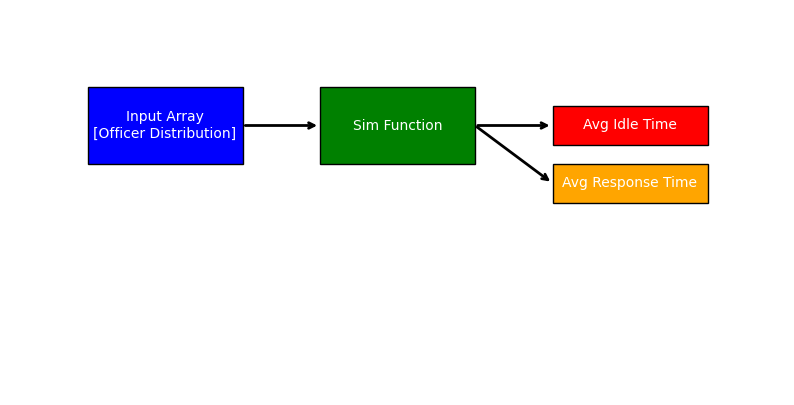

In [84]:
import matplotlib.pyplot as plt

# Define the coordinates for the rectangles and arrows
input_coords = (0.1, 0.6)
function_coords = (0.4, 0.6)
output_coords_idle = (0.7, 0.65)
output_coords_response = (0.7, 0.5)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Hide the axes
ax.axis('off')

# Create the rectangles for input, function, and output
input_rect = plt.Rectangle(input_coords, 0.2, 0.2, fc='blue', ec='black')
function_rect = plt.Rectangle(function_coords, 0.2, 0.2, fc='green', ec='black')
output_rect_idle = plt.Rectangle(output_coords_idle, 0.2, 0.1, fc='red', ec='black')
output_rect_response = plt.Rectangle(output_coords_response, 0.2, 0.1, fc='orange', ec='black')

# Add the rectangles to the plot
ax.add_patch(input_rect)
ax.add_patch(function_rect)
ax.add_patch(output_rect_idle)
ax.add_patch(output_rect_response)

# Add text for each rectangle
ax.text(input_coords[0] + 0.1, input_coords[1] + 0.1, 'Input Array\n[Officer Distribution]', ha='center', va='center', color='white')
ax.text(function_coords[0] + 0.1, function_coords[1] + 0.1, 'Sim Function', ha='center', va='center', color='white')
ax.text(output_coords_idle[0] + 0.1, output_coords_idle[1] + 0.05, 'Avg Idle Time', ha='center', va='center', color='white')
ax.text(output_coords_response[0] + 0.1, output_coords_response[1] + 0.05, 'Avg Response Time', ha='center', va='center', color='white')

# Add arrows between the rectangles
ax.annotate('', xy=(input_coords[0] + 0.2, input_coords[1] + 0.1), xytext=(function_coords[0], function_coords[1] + 0.1),
            arrowprops=dict(arrowstyle='<-', lw=2))
ax.annotate('', xy=(function_coords[0] + 0.2, function_coords[1] + 0.1), xytext=(output_coords_idle[0], output_coords_idle[1] + 0.05),
            arrowprops=dict(arrowstyle='<-', lw=2))
ax.annotate('', xy=(function_coords[0] + 0.2, function_coords[1] + 0.1), xytext=(output_coords_response[0], output_coords_response[1] + 0.05),
            arrowprops=dict(arrowstyle='<-', lw=2))

# Save the figure
plt.savefig('../img/simulation_io_diagram.png', bbox_inches='tight')

# Show the plot
plt.show()


In [85]:
import pandas as pd
from tabulate import tabulate

# Create a DataFrame to store the shift schedule
data = {
    "Shifts": ["Early", "Day", "Night"],
    "Stations": ["Station 1", "Station 2", "Station 3"],
    "Start Time": ["00:00 AM", "08:00 AM", "03:00 PM"],
    "End Time": ["07:59 AM", "02:59 PM", "11:59 AM"]
}

df = pd.DataFrame(data)

# Display the formatted shift schedule table
table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)



╒══════════╤════════════╤══════════════╤════════════╕
│ Shifts   │ Stations   │ Start Time   │ End Time   │
╞══════════╪════════════╪══════════════╪════════════╡
│ Early    │ Station 1  │ 00:00 AM     │ 07:59 AM   │
├──────────┼────────────┼──────────────┼────────────┤
│ Day      │ Station 2  │ 08:00 AM     │ 02:59 PM   │
├──────────┼────────────┼──────────────┼────────────┤
│ Night    │ Station 3  │ 03:00 PM     │ 11:59 AM   │
╘══════════╧════════════╧══════════════╧════════════╛


[7, 4, 2, 4, 2]
[21, 13, 10, 12, 9]


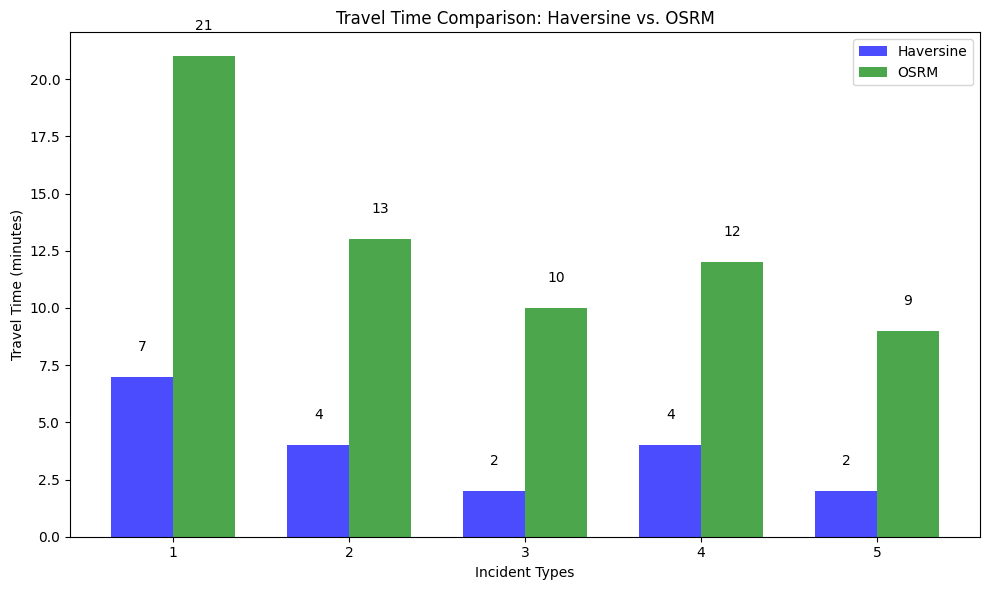

In [86]:
import matplotlib.pyplot as plt

# Sample data for travel times
incident_types = []
count = 5

for i in range(1, count+1):
    incident_types.append(str(i))

incident_data1 = incident_data.head(count)

haversine_times = []
osrm_times = []

for index, incident in incident_data1.iterrows():
    osrm_times.append(int(incident['travel_time']))  # Travel times calculated using Haversine (in minutes)
    closest_station = incident['closest_station']
    station_lat = station_locations[closest_station]['Latitude']
    station_lon = station_locations[closest_station]['Longitude'] 
    haversine_times.append(int(haversine_distance(station_lat, station_lon, incident['Latitude'], incident['Longitude']))) # Travel times obtained from OSRM (in minutes)

print(haversine_times)
print(osrm_times)

# Create a bar chart to compare travel times
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(incident_types))

bar1 = plt.bar(index, haversine_times, bar_width, label='Haversine', color='b', alpha=0.7)
bar2 = plt.bar([i + bar_width for i in index], osrm_times, bar_width, label='OSRM', color='g', alpha=0.7)

plt.xlabel('Incident Types')
plt.ylabel('Travel Time (minutes)')
plt.title('Travel Time Comparison: Haversine vs. OSRM')
plt.xticks([i + bar_width/2 for i in index], incident_types)
plt.legend()

# Add data labels above the bars
for i in index:
    plt.text(i, haversine_times[i] + 1, str(haversine_times[i]), ha='center', va='bottom')
    plt.text(i + bar_width, osrm_times[i] + 1, str(osrm_times[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()


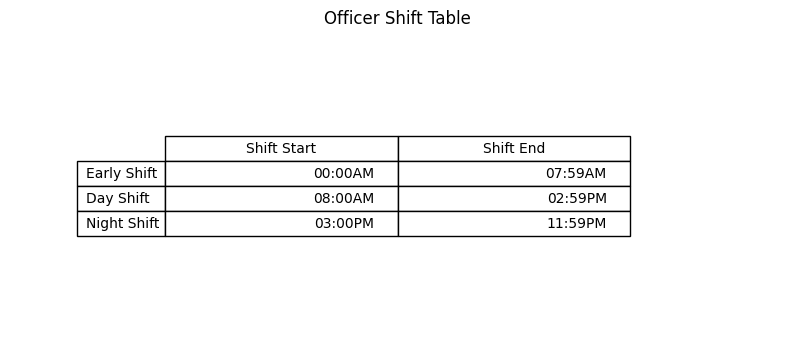

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data: replace with your actual data
data = {
    'Shifts': ['Early Shift', 'Day Shift', 'Night Shift'],
    'Shift Start': ['00:00AM', '08:00AM', '03:00PM'],
    'Shift End': ['07:59AM', '02:59PM', '11:59PM']
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Setting the index to 'Officer'
df.set_index('Shifts', inplace=True)

# Plot size
fig, ax = plt.subplots(figsize=(10, 4)) 

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Tabulate data
tab = plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

# Adjust table
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(0.6, 1.5)

plt.title('Officer Shift Table')

# Show the plot
plt.show()


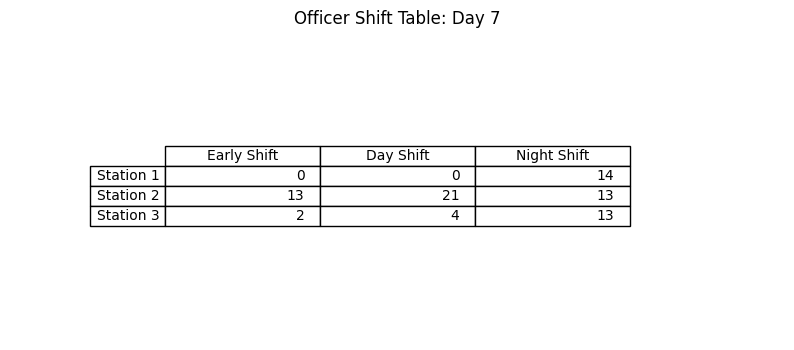

In [88]:
# Officer Distrobution
import matplotlib.pyplot as plt
import pandas as pd

# Sample data: replace with your actual data
data = {
    'Stations': ['Station 1', 'Station 2', 'Station 3'],
    'Early Shift': [0, 13, 2],
    'Day Shift': [0, 21, 4],
    'Night Shift': [14, 13, 13]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Setting the index to 'Officer'
df.set_index('Stations', inplace=True)

# Plot size
fig, ax = plt.subplots(figsize=(10, 4)) 

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Tabulate data
tab = plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

# Adjust table
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(0.6, 1.2)

plt.title('Officer Shift Table: Day 7')

# Show the plot
plt.show()


Day: '7' shift: 'Early'
Officers in Station 1: 0
Officers in Station 2: 13
Officers in Station 3: 2

Allocating Officer from Station 3 to Incident at (55.871751, -4.2883598) at Time: 00:00
Officer from Station 3 handled an incident. finshed at Day: 7 time: 02:10 Hrs.


Allocating Officer from Station 2 to Incident at (55.920889, -4.2079638) at Time: 00:00
Officer from Station 2 handled an incident. finshed at Day: 7 time: 02:12 Hrs.


Allocating Officer from Station 3 to Incident at (55.864601, -4.3524924) at Time: 00:00
Officer from Station 3 handled an incident. finshed at Day: 7 time: 02:39 Hrs.


Allocating Officer from Station 2 to Incident at (55.855421, -4.1260991) at Time: 00:00
Officer from Station 2 handled an incident. finshed at Day: 7 time: 02:23 Hrs.


Allocating Officer from Station 2 to Incident at (55.89106, -4.2304021) at Time: 00:00
Officer from Station 2 handled an incident. finshed at Day: 7 time: 02:35 Hrs.


Allocating Officer from Station 2 to Incident at (55.86

### Solutions
##### Run 1 - Day 1 - Gen 100
- 
- 

To do
- **Write the report**

The deadline for submission of the development phase is **23:59 10 January 2024**

##### At the end of this phase you should send to ORchallenge@ed.ac.uk the following documents: 

- A pdf document of at most 10 pages, excluding appendices, with the detailed explanation of the approach you used, the computations performed, and the logical thinking supporting your recommendations, explaining the limitations of your modelling approach, and stating any caveats that apply to your results.

- A second pdf document of 1 page that is a business report to be given to the client. You do not need to include any technical details in this report. The information needs to be convincing enough for the client to pick your solution.

\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage{graphicx}

\begin{document}

\begin{titlepage}
    \centering
    \vspace*{1cm}
    
    \textbf{\Large Optimisation of Police Resource Allocation: A Theoretical Approach}
    
    \vspace{1.5cm}
    
    \textbf{Muhammad Sami Munawar}
    
    \vfill
    
    A report presented for\\
    Theoretical Physics (BSc)\\
    University of Edinburgh
    
    \vspace{1.5cm}
    
    \includegraphics[width=0.4\textwidth]{university-logo.png} % Replace 'university-logo.png' with your university's logo file
    
    \vspace{1cm}
    
    \Large
    \today
    
\end{titlepage}

\end{document}
